lets activate Autoreload in order to all changed code before any execution

In [1]:
%reload_ext autoreload
%autoreload 2

# Lets imoprt all the libraries we need

In [2]:
# ---------------------------------- Models ---------------------------------- #
from darts.models import TFTModel, Prophet, NBEATSModel, LightGBMModel, RandomForest
from darts.dataprocessing.transformers import Scaler
import torch

# ---------------------------------- Tabular --------------------------------- #
import pandas as pd
import numpy as np

# ----------------------------------- Utils ---------------------------------- #
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.metrics import mape, mase
import os

Importing plotly failed. Interactive plots will not work.


In [3]:
# check if working in colab
try:
    # In colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/projects/paris-traffic-forecast
    %pip install -q darts

except:
    # In local
    A = %pwd
    if A.split('/')[-1] == "notebooks":
        %cd ..
%pwd

/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast


'/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast'

## Needs

Prior to executing this notebook you should have your data in the data folder, please execute the bash script `data_src/get_data.sh` to download the data.

In [4]:
# !./data_src/get_data.sh

# Get data

In [5]:
data_paths = ["data/AV_Champs_Elysees.csv", "data/Convention.csv", "data/Sts_Peres.csv"]
time_col = "Date et heure de comptage"
input_cols = ["Date et heure de comptage"]
output_cols = ["Débit horaire", "Taux d'occupation"]

df = pd.read_csv(data_paths[0], sep=";").sort_values(time_col)
# print("all data :")
# display(df.head(2))
print("Important data :")
display(df[input_cols+output_cols].tail())

Important data :


,Date et heure de comptage,Débit horaire,Taux d'occupation
4180,2021-12-14T20:00:00+01:00,1197.0,26.70056
4153,2021-12-14T21:00:00+01:00,1161.0,23.94667
4154,2021-12-14T22:00:00+01:00,974.0,19.09944
4181,2021-12-14T23:00:00+01:00,930.0,16.94222
4182,2021-12-15T00:00:00+01:00,891.0,15.84945


Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


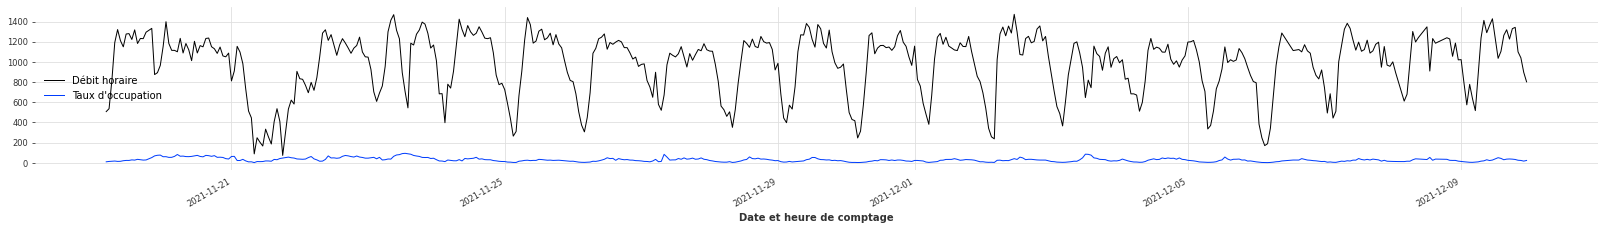

In [6]:
# ------------------------------ Other approach ------------------------------ #
# X = pd.DatetimeIndex(pd.to_datetime(df['Date et heure de comptage'], utc=True).dt.tz_localize(None))
# Y = df[output_cols]

# ---------------------------- Nouamane's approach --------------------------- #
new_df = df.copy()
new_df[time_col] = pd.to_datetime(df[time_col], utc=True).dt.tz_localize(None)
new_df[time_col] = pd.DatetimeIndex(new_df[time_col])
new_df = new_df.set_index(time_col)

ts = TimeSeries.from_dataframe(new_df, 
                          value_cols=output_cols,
                          fill_missing_dates=True,
                          freq='H')

# ------------------------------ Missing values ------------------------------ #
print("Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan")
ts._xa.values = pd.DataFrame(ts.values()).interpolate().to_numpy().reshape((-1, len(output_cols), 1)) #Not the most intuitive way to do it, but it works with one line of code :D
# ---------------------------------- Ploting --------------------------------- #
# fig, _ = plt.subplots(figsize=(28, 4))
# ts[-900:].plot(lw=1, figure = fig)
plt.figure(figsize=(28, 3))
ts[-500:].plot(lw=1)

# Play ground

# Model testing

In [7]:
model = TFTModel(n_epochs=2000, batch_size=128, add_relative_index=True, optimizer_kwargs={"lr": 0.02})
predict_preiod = 24*5
# train, val = ts[:-predict_preiod], ts[-predict_preiod:]
delta = pd.Timedelta(str(predict_preiod)+' H')
split_time = ts.time_index[-1] - delta
train, val = ts.split_after(split_time)

In [8]:
# model.fit(train, past_covariates=train)
model.fit(train)

[2021-12-10 09:25:58,599] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3537 samples.
[2021-12-10 09:25:58,599] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3537 samples.
[2021-12-10 09:25:58,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 09:25:58,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


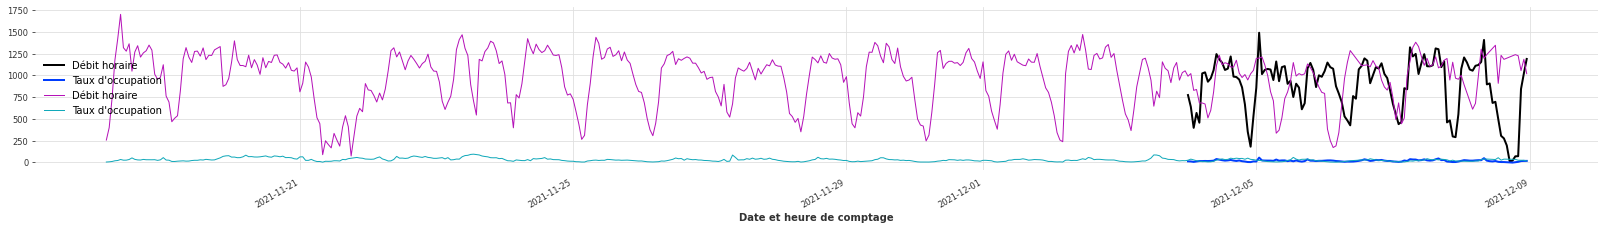

In [9]:
# tmp = TimeSeries.concatenate(train, val[:15])
# pred = model.predict(16, past_covariates=tmp)
pred = model.predict(predict_preiod)
plt.figure(figsize=(28, 3))
pred[-500:].plot(lw=2)
ts[-500:].plot(lw=1)

### Other

In [8]:
model_2 = TFTModel(n_epochs=10, batch_size=512, add_relative_index=True, optimizer_kwargs={"lr": 0.02}, hidden_size=4, input_chunk_length=128)
model_2.fit(train, verbose=True)

[2021-12-12 19:07:09,219] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9445 samples.
[2021-12-12 19:07:09,219] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9445 samples.
[2021-12-12 19:07:09,416] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-12 19:07:09,416] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


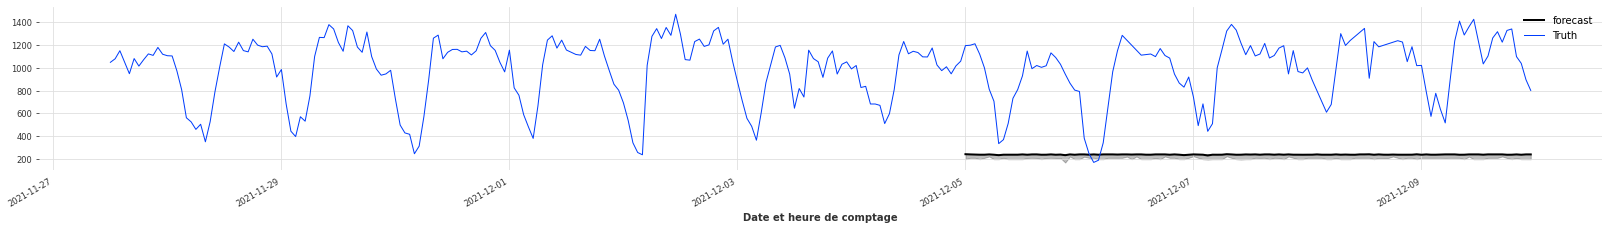

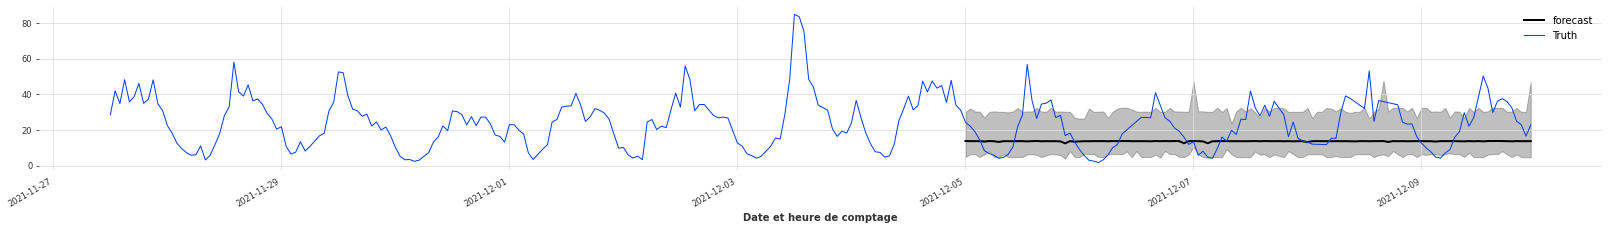

In [10]:
pred = model_2.predict(predict_preiod, num_samples=100)
for output in output_cols:
    plt.figure(figsize=(28, 3))
    pred[output].plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    ts[output][-300:].plot(label="Truth", lw=1)
    plt.show()

## Other

In [8]:
tiny_train = train[-1000:]

In [11]:
parameters = {
    "optimizer_kwargs" : [{"lr": 0.02}, {"lr": 0.05}],
    "input_chunk_length" : [64, 128, 256],
    "hidden_size" : [4, 8, 16],
    "add_relative_index" : [True],
    "batch_size" : [256],
    "n_epochs" : [10],
}

model_2 = TFTModel()

best_found = model_2.gridsearch(
    parameters=parameters,
    series = tiny_train[:-predict_preiod], 
    val_series = tiny_train[-predict_preiod:],
    last_points_only=False,
    metric=mape,
    reduction=np.mean,
    verbose=True)

  0%|          | 0/18 [00:00<?, ?it/s]

[2021-12-10 16:07:34,393] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 816 samples.
[2021-12-10 16:07:34,393] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 816 samples.
[2021-12-10 16:07:34,404] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 16:07:34,404] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[2021-12-10 16:07:48,094] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 816 samples.
[2021-12-10 16:07:48,094] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 816 samples.
[2021-12-10 16:07:48,107] INFO | darts.mo

In [17]:
best_model = best_found[0]
best_model.fit(tiny_train)

[2021-12-10 16:14:24,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 936 samples.
[2021-12-10 16:14:24,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 936 samples.
[2021-12-10 16:14:24,654] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 16:14:24,654] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


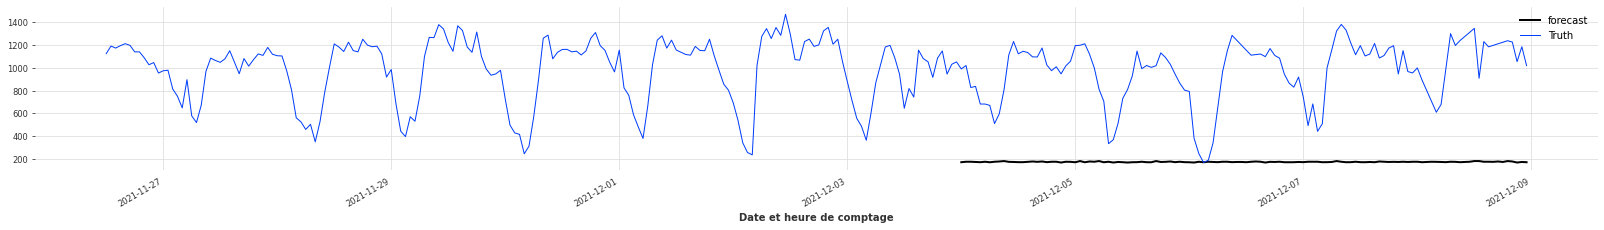

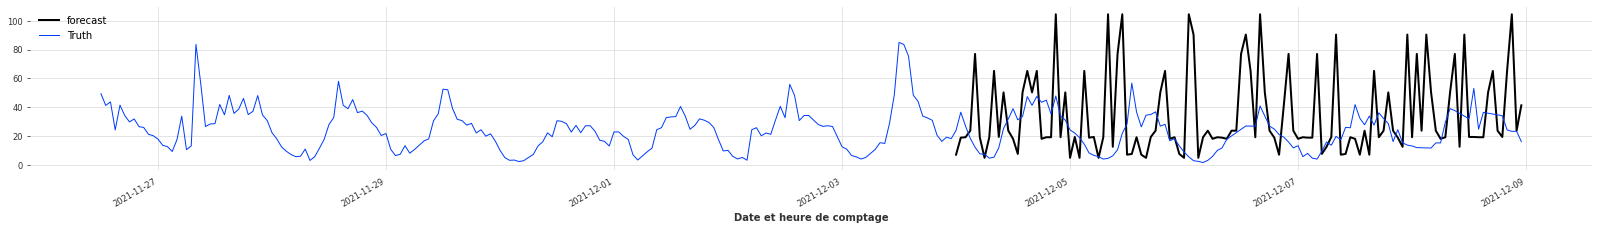

In [19]:
pred = best_model.predict(predict_preiod)
for output in output_cols:
    plt.figure(figsize=(28, 3))
    pred[output].plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    ts[output][-300:].plot(label="Truth", lw=1)
    plt.show()

In [33]:
pred.to_csv("data/pred.csv")

## Backtesting

In [ ]:
model_2 = TFTModel(input_chunk_length=24, output_chunk_length=1, add_relative_index =True, full_attention = False, num_attention_heads=1, lstm_layers = 1, hidden_size=3)
errors = model_2.backtest(train[-1000:][output_cols[0]], verbose=True, stride=100, last_points_only=False, reduction=None, forecast_horizon=predict_preiod, metric=mape)

plt.figure(figsize=(28, 3))
plt.plot(errors)
# pred = model.predict(predict_preiod)
# pred[-500:].plot(lw=2)
# ts[-500:].plot(lw=1)
# plt.show()
# print("mape :", mape(val[output_cols[0]], pred))
# print("mase :", mase(val[output_cols[0]], pred))

In [64]:
errors

[95.32916671647429, 81.76776640379903, 64.89919955515187, 46.14954703316831]

# Speed prediction

## get data

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


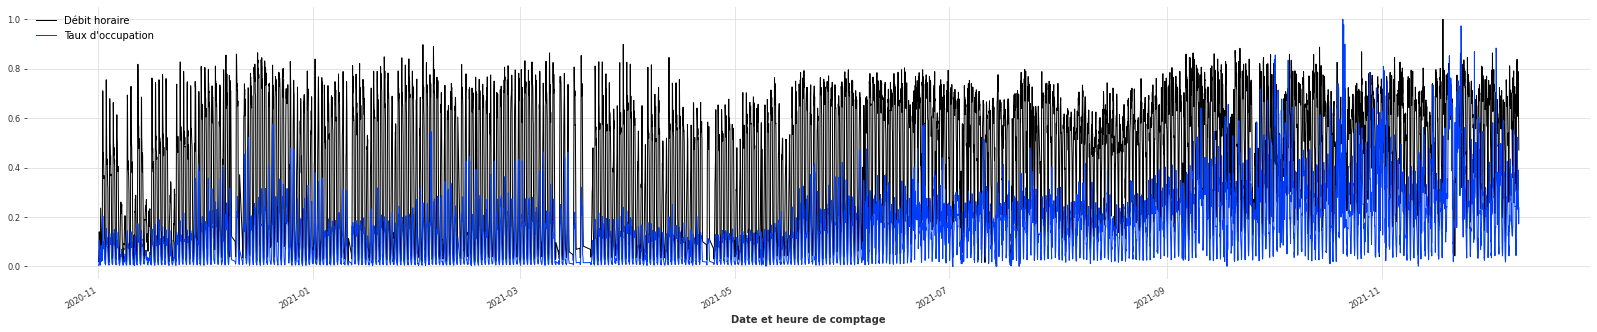

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


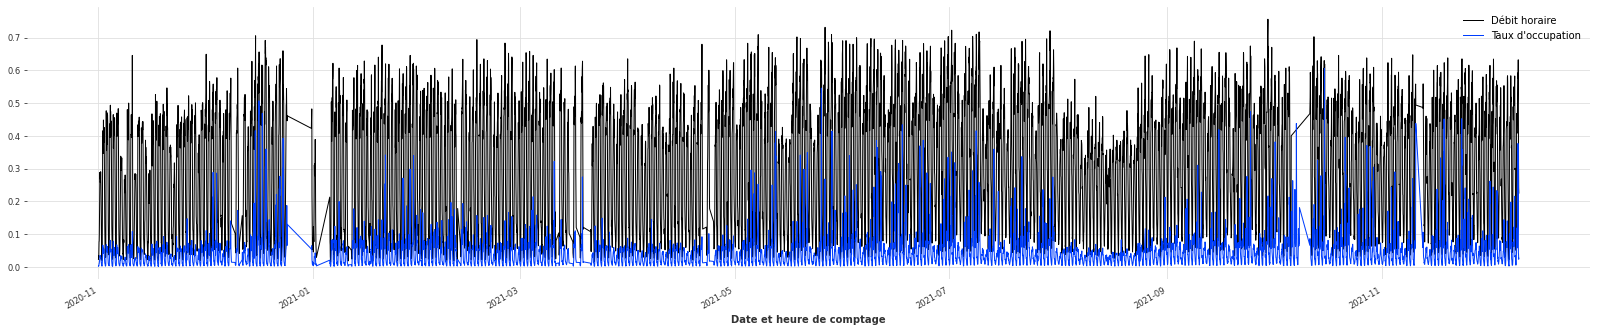

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


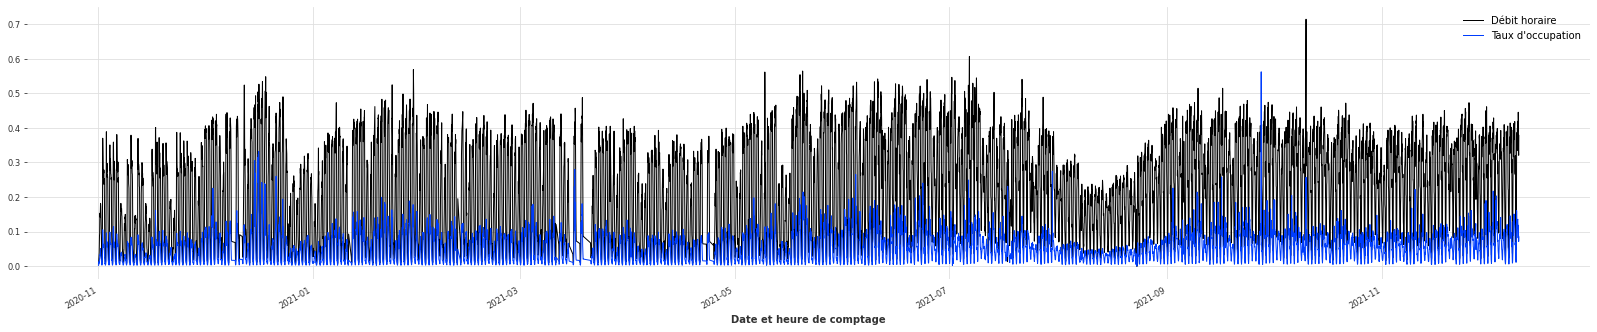

In [11]:
data_paths = ["data/AV_Champs_Elysees.csv", "data/Convention.csv", "data/Sts_Peres.csv"]
time_col = "Date et heure de comptage"
input_cols = ["Date et heure de comptage"]
output_cols = ["Débit horaire", "Taux d'occupation"]

scaler = Scaler()
first = True 

dfs = []
time_series = []
for path in data_paths:
    plt.figure(figsize=(28, 5))
    df = pd.read_csv(path, sep=";", decimal=",", parse_dates=[time_col])
    df[time_col] = pd.to_datetime(df[time_col], utc=True).dt.tz_localize(None)
    df[time_col] = pd.DatetimeIndex(df[time_col])
    df = df.set_index(time_col)
    dfs.append(df)


    ts = TimeSeries.from_dataframe(df, 
                            value_cols=output_cols,
                            fill_missing_dates=True,
                            freq='H')
    # ------------------------------ Missing values ------------------------------ #
    print("Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan")
    ts._xa.values = pd.DataFrame(ts.values()).interpolate().to_numpy().reshape((-1, len(output_cols), 1)) #Not the most intuitive way to do it, but it works with one line of code :D

    if first:
        ts_transformed = scaler.fit_transform(ts)
        first = False
    else:
        ts_transformed = scaler.transform(ts)
    ts_transformed.plot(lw=1)
    time_series.append(ts_transformed)
    plt.show()
# df = pd.read_csv(data_paths[0], sep=";").sort_values(time_col)
train, val  = [], []
for ts in time_series:
    train.append(ts[:-predict_preiod])
    val.append(ts[-predict_preiod:])

In [14]:
predict_preiod = 24*5
my_model = NBEATSModel(input_chunk_length=24*7, 
                    output_chunk_length=24,
                    n_epochs=100, random_state=0, 
                    optimizer_kwargs={'lr': 1e-3}, 
                    batch_size=128)

my_model.fit(train, verbose=True)


[2021-12-11 15:14:33,946] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28146 samples.
[2021-12-11 15:14:33,946] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28146 samples.
[2021-12-11 15:14:34,549] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-11 15:14:34,549] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
prediction.columns

Index(['Débit horaire', 'Taux d'occupation'], dtype='object', name='component')

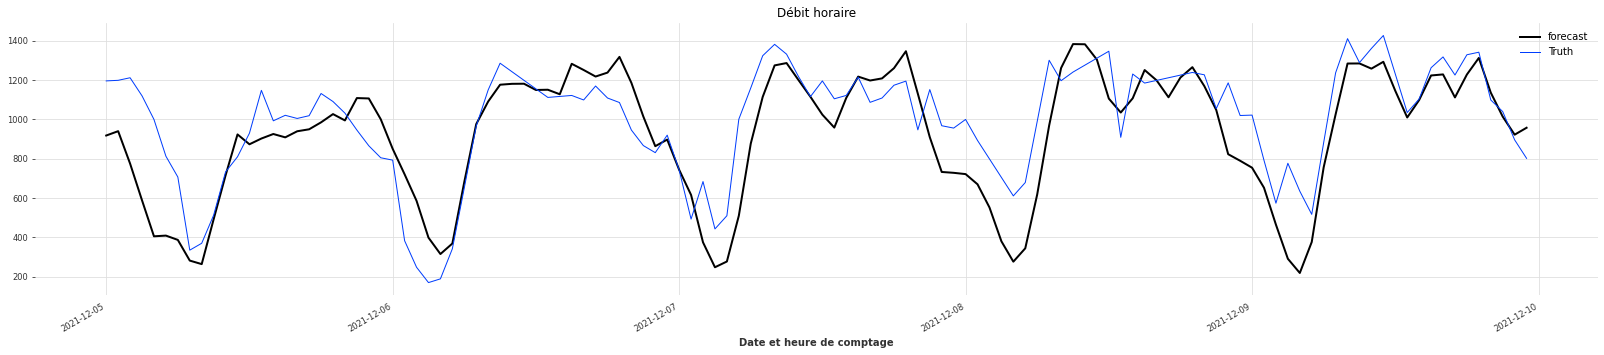

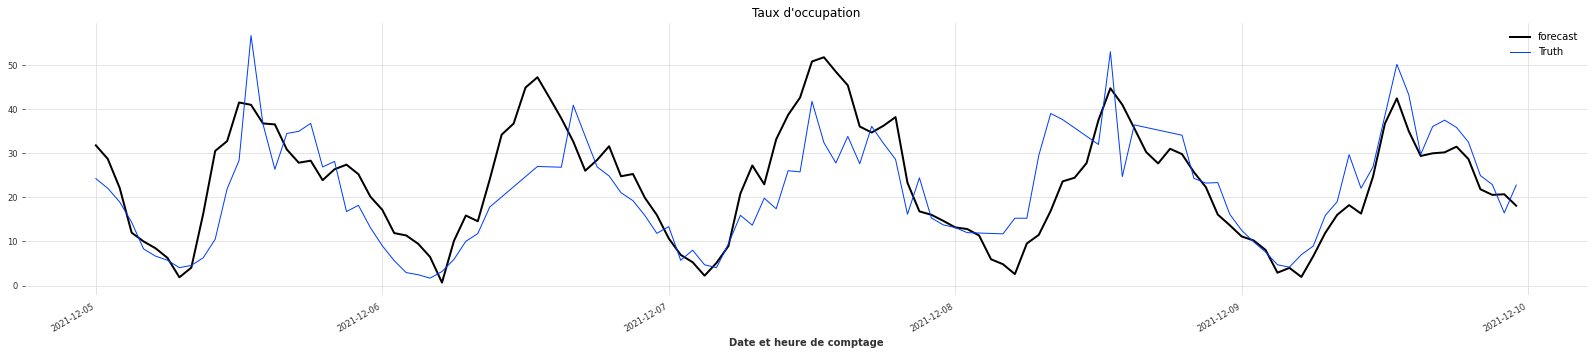

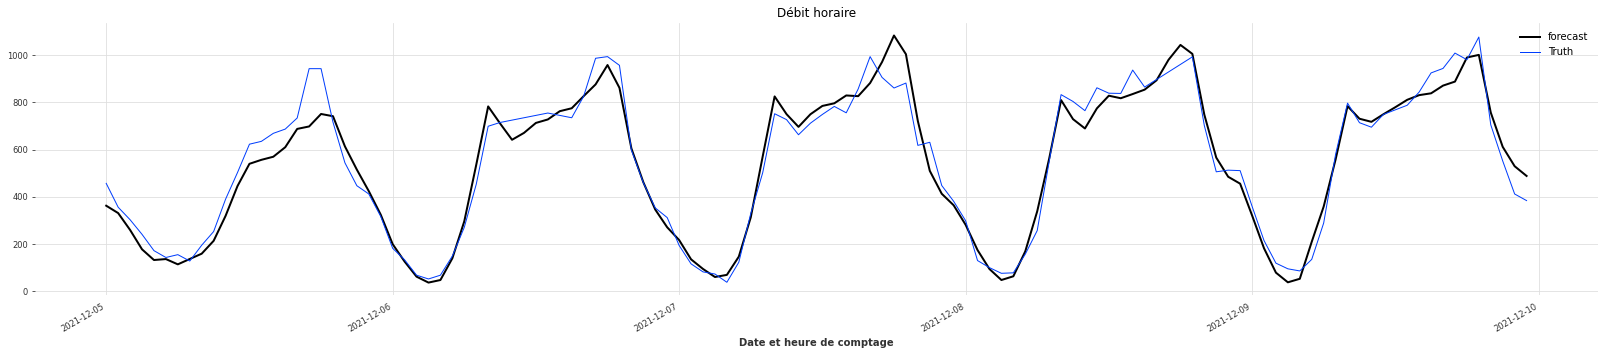

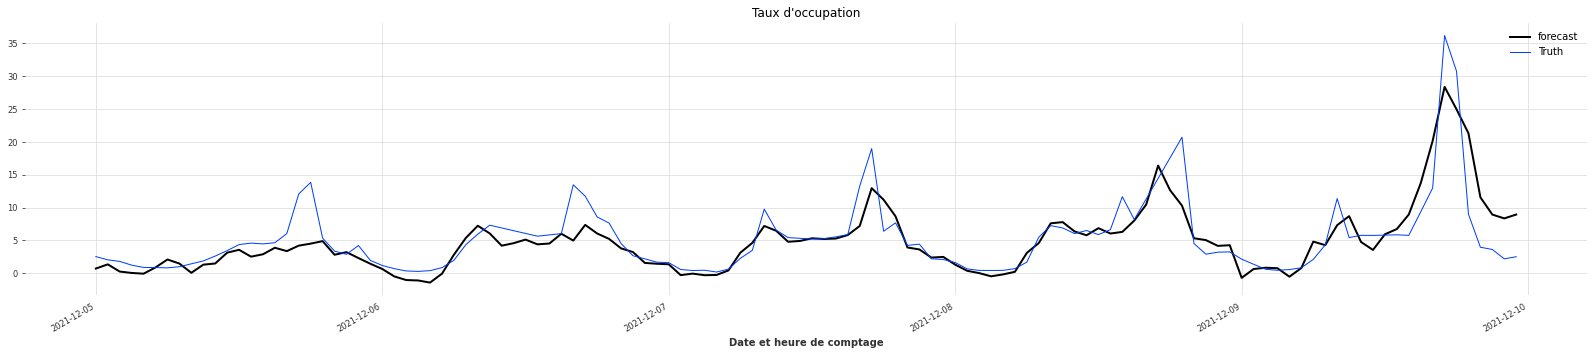

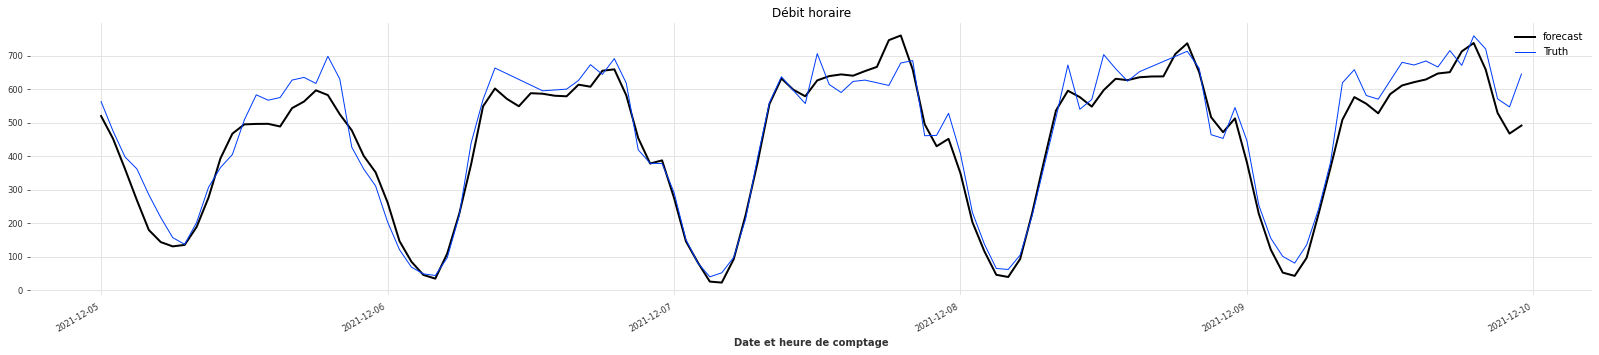

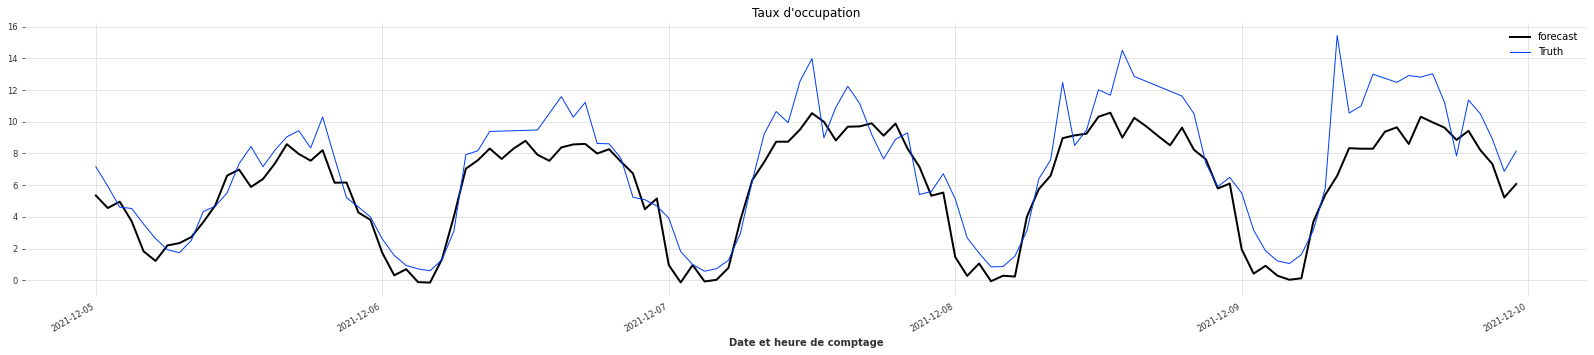

In [32]:
pred = my_model.predict(predict_preiod, series=train)

for i,prediction in enumerate(pred):
    # prediction.plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    # val[i].plot(label="Truth", lw=1)
    real_scale_pred = scaler.inverse_transform(prediction)
    real_scale_val = scaler.inverse_transform(val[i])
    
    plt.figure(figsize=(28, 5))
    real_scale_pred['Débit horaire'].plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    real_scale_val['Débit horaire'].plot(label="Truth", lw=1)
    #create directory results before saving
    os.makedirs("results", exist_ok=True)
    plt.title("Débit horaire")
    plt.savefig("results/debit"+str(i+1)+".png", dpi=300)
    plt.show()
    
    plt.figure(figsize=(28, 5))
    real_scale_pred["Taux d'occupation"].plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    real_scale_val["Taux d'occupation"].plot(label="Truth", lw=1)
    plt.title("Taux d'occupation")
    plt.savefig("results/taux"+str(i+1)+".png", dpi=300)
    plt.show()
# pred
# plt.figure(figsize=(28, 3))
# pred[-500:].plot(lw=2)
# ts[-500:].plot(lw=1)

# Third prediction

## get data

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


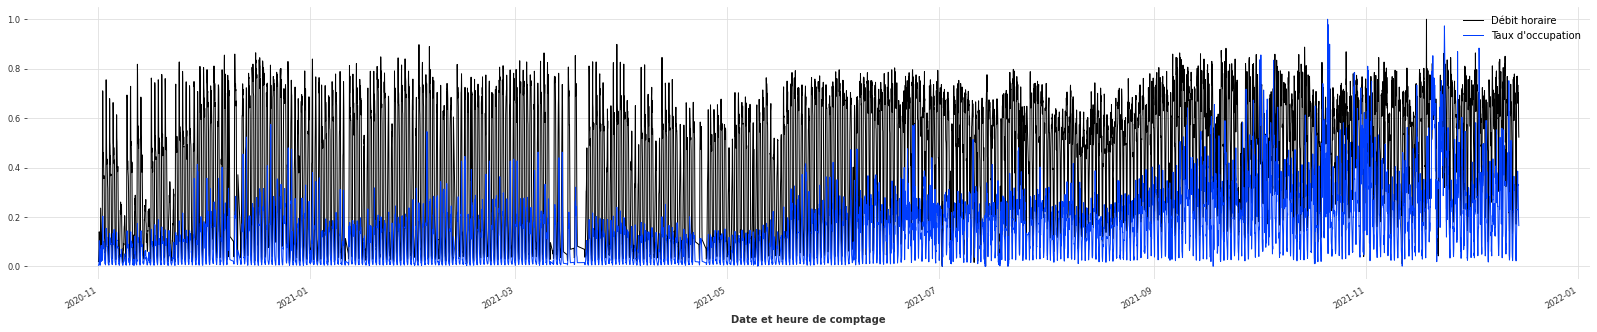

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


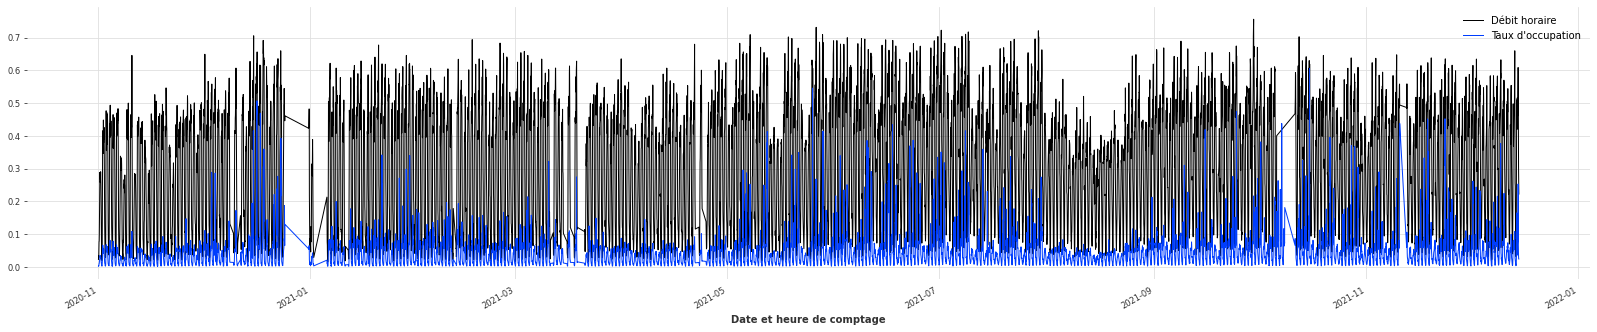

Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


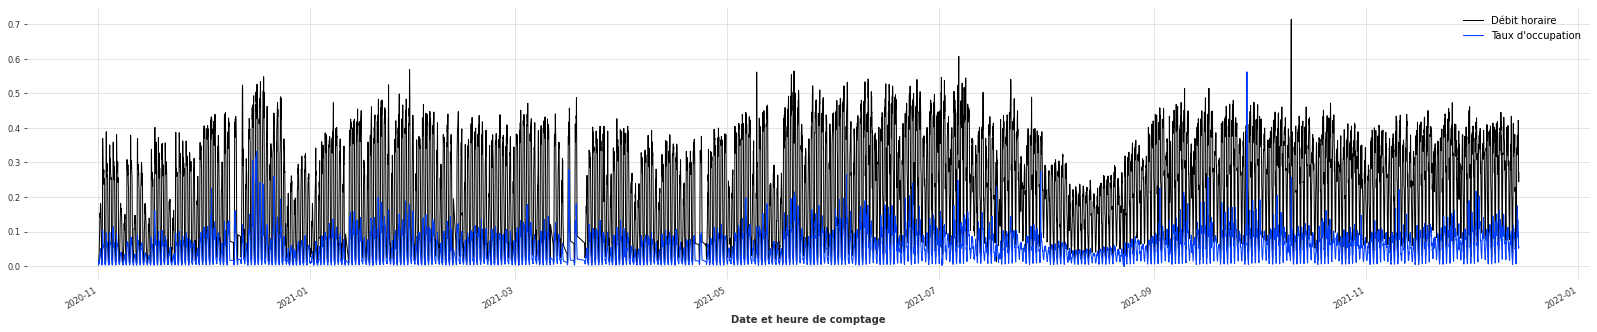

In [4]:
predict_preiod = 24*5
# data_paths = ["data/champs_elysees-2014-2021.csv", "data/convention-2014-2021.csv", "data/sts_peres-2014-2021.csv"]
# time_col = "time"
# input_cols = ["time"]
# output_cols = ["debit", "occupation"]
data_paths = ["data/AV_Champs_Elysees.csv", "data/Convention.csv", "data/Sts_Peres.csv"]
time_col = "Date et heure de comptage"
input_cols = ["Date et heure de comptage"]
output_cols = ["Débit horaire", "Taux d'occupation"]

scaler = Scaler()
first = True 

dfs = []
time_series = []
for path in data_paths:
    plt.figure(figsize=(28, 5))
    # df = pd.read_csv(path, parse_dates=[time_col])
    df = pd.read_csv(path, sep=";").sort_values(time_col)
    df[time_col] = pd.to_datetime(df[time_col], utc=True).dt.tz_localize(None)
    df[time_col] = pd.DatetimeIndex(df[time_col])
    df = df.set_index(time_col)
    dfs.append(df)


    ts = TimeSeries.from_dataframe(df, 
                            value_cols=output_cols,
                            fill_missing_dates=True,
                            freq='H')
    # ------------------------------ Missing values ------------------------------ #
    print("Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan")
    ts._xa.values = pd.DataFrame(ts.values()).interpolate().to_numpy().reshape((-1, len(output_cols), 1)) #Not the most intuitive way to do it, but it works with one line of code :D

    if first:
        ts_transformed = scaler.fit_transform(ts)
        first = False
    else:
        ts_transformed = scaler.transform(ts)
    ts_transformed.plot(lw=1)
    time_series.append(ts_transformed)
    plt.show()
# df = pd.read_csv(data_paths[0], sep=";").sort_values(time_col)
train, val  = [], []
for ts in time_series:
    # train.append(ts[:-predict_preiod])
    train.append(ts[:-predict_preiod])
    val.append(ts[-predict_preiod:])

In [17]:
predict_preiod = 24*5
# model_name = "nbeats"
# my_model = NBEATSModel(input_chunk_length=24*7, 
#                     output_chunk_length=24,
#                     n_epochs=100, random_state=0, 
#                     optimizer_kwargs={'lr': 1e-3},
#                     batch_size=512)
model_name = "nbeats"
my_model = NBEATSModel(input_chunk_length=24*7, 
                    output_chunk_length=predict_preiod,
                    n_epochs=40, random_state=0, 
                    optimizer_kwargs={'lr': 1e-3},
                    # add_relative_index=True,
                    # optimizer_cls= torch.optim.SGD,
                    # lr_scheduler_cls = torch.optim.lr_scheduler.StepLR,
                    # lr_scheduler_kwargs = {'step_size': 30, 'gamma': 0.8},
                    batch_size=32)
# model_name = "RF"
# my_model = RandomForest(lags=200)
# model_name = "lightgbm"
# my_model = LightGBMModel(lags=200)

my_model.fit(train, verbose=True)


[2021-12-16 17:02:37,193] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28218 samples.
[2021-12-16 17:02:37,193] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28218 samples.


  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
my_model.fit(train, verbose=True)

[2021-12-16 17:17:19,839] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28218 samples.
[2021-12-16 17:17:19,839] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 28218 samples.


  0%|          | 0/10 [00:00<?, ?it/s]

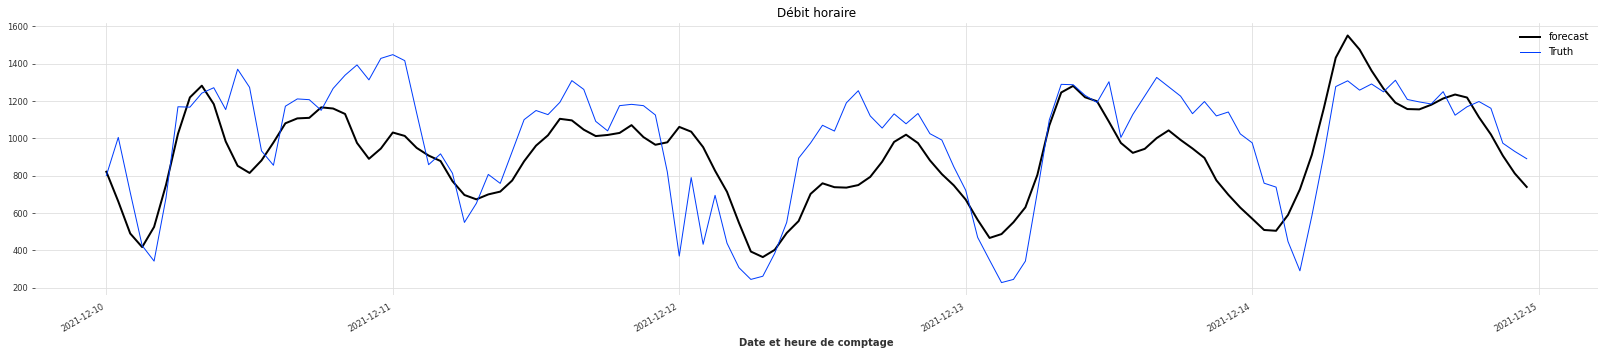

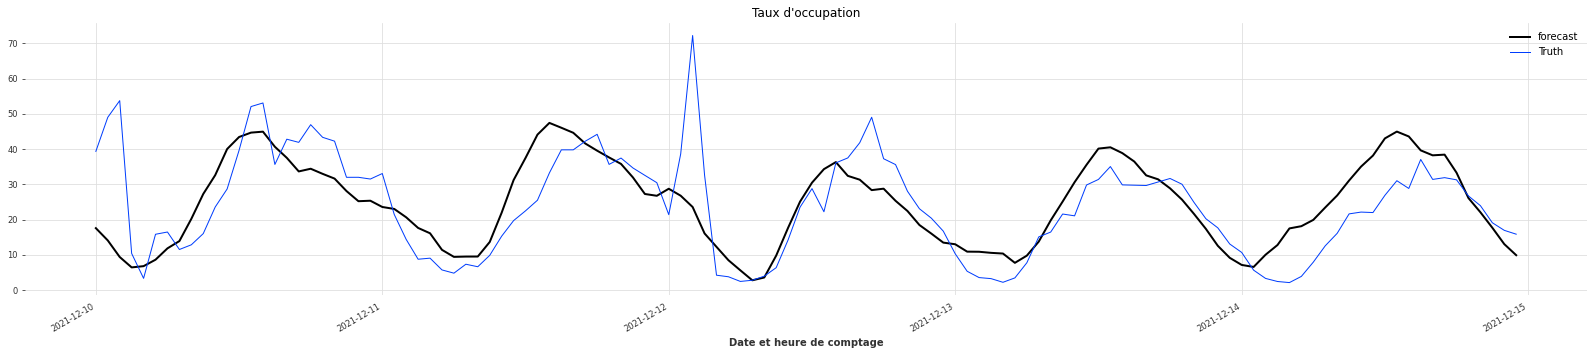

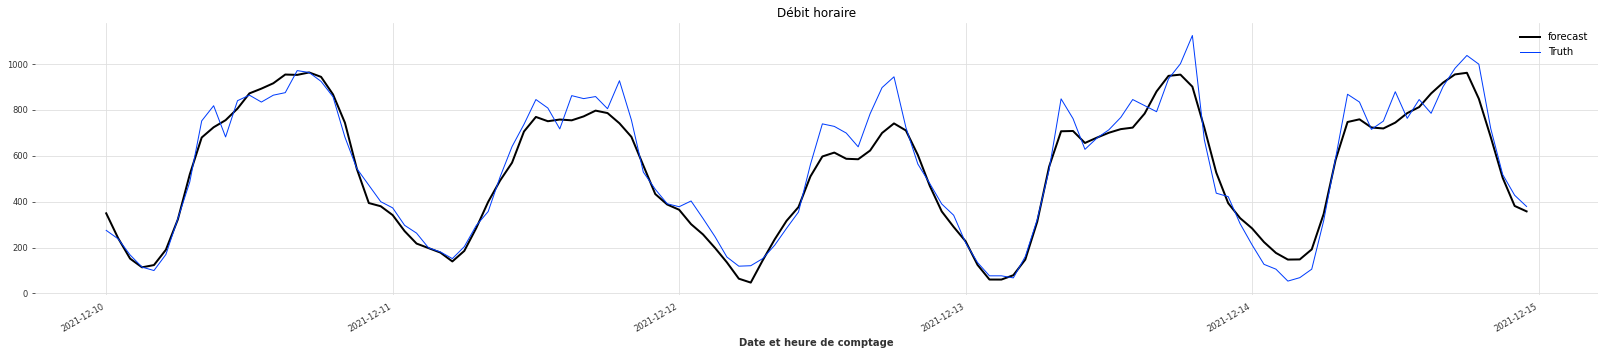

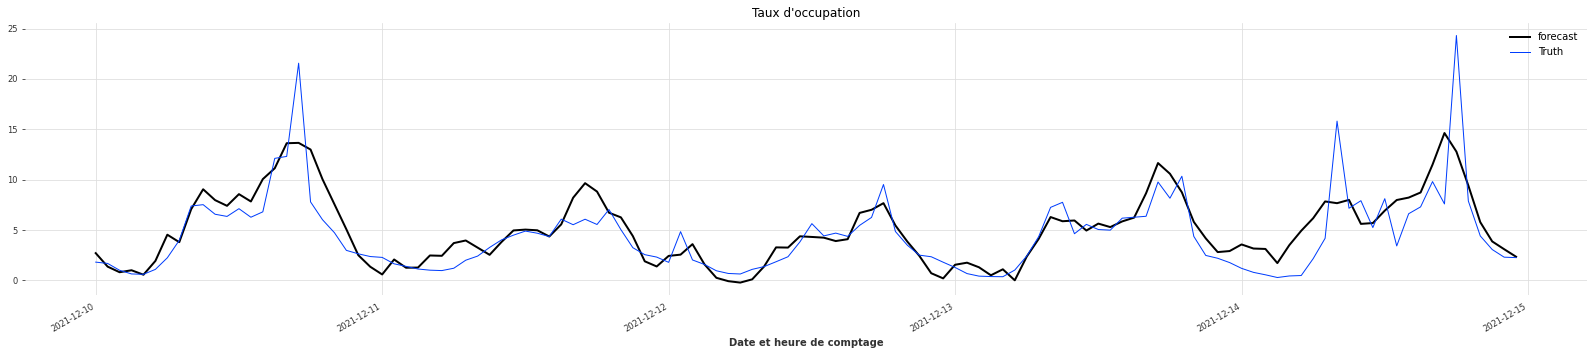

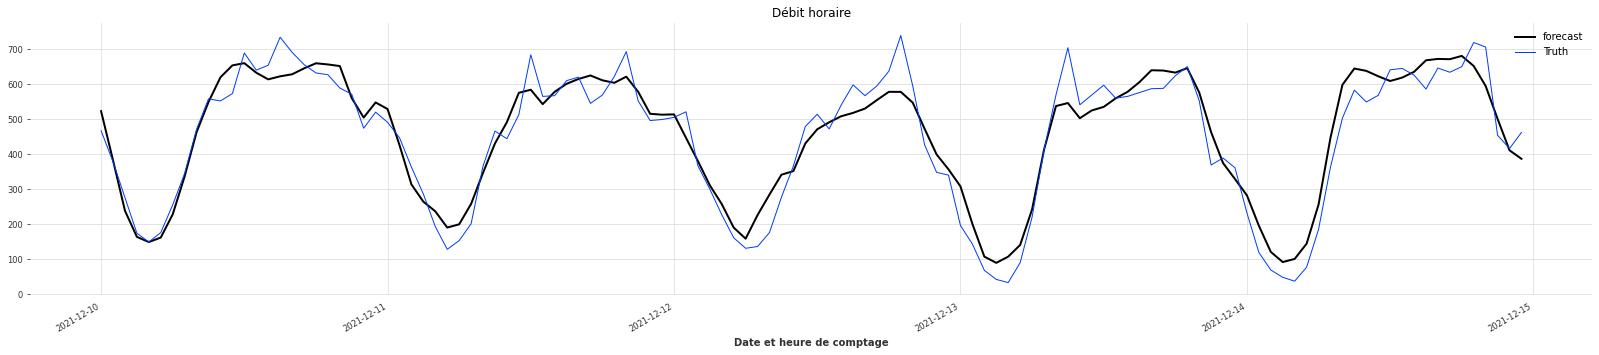

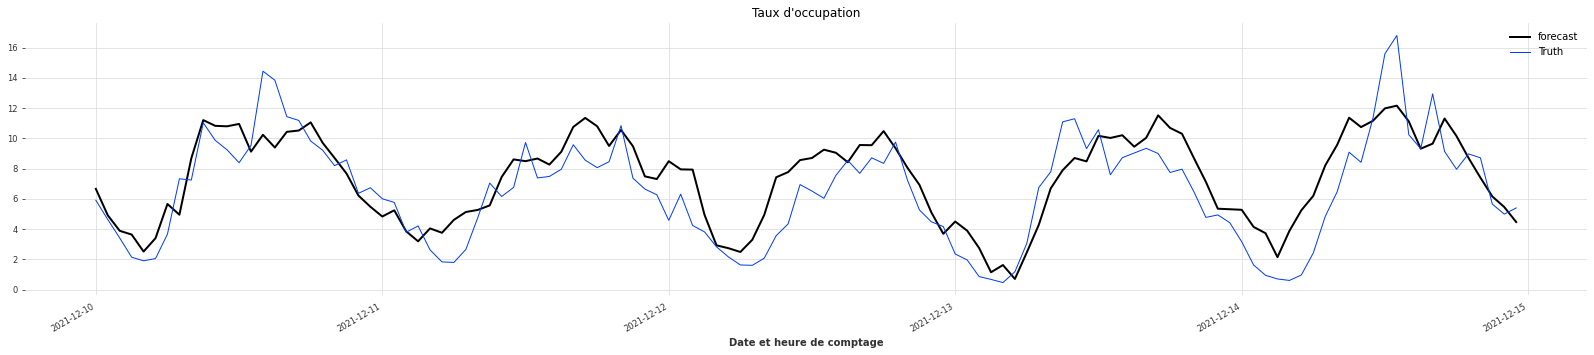

In [22]:
pred = my_model.predict(predict_preiod, series=train, num_samples = 300)

for i,prediction in enumerate(pred):
    # prediction.plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    # val[i].plot(label="Truth", lw=1)
    real_scale_pred = scaler.inverse_transform(prediction)
    real_scale_val = scaler.inverse_transform(val[i])
    
    plt.figure(figsize=(28, 5))
    real_scale_pred[output_cols[0]].plot(label= "forecast", lw=2, low_quantile=0.4, high_quantile=0.6)
    real_scale_val[output_cols[0]].plot(label="Truth", lw=1)
    #create directory results before saving
    os.makedirs("results", exist_ok=True)
    plt.title("Débit horaire")
    plt.savefig("results/debit_long"+str(i+1)+".png", dpi=300)
    plt.show()
    
    plt.figure(figsize=(28, 5))
    real_scale_pred[output_cols[1]].plot(label= "forecast", lw=2, low_quantile=0.4, high_quantile=0.6)
    real_scale_val[output_cols[1]].plot(label="Truth", lw=1)
    plt.title("Taux d'occupation")
    plt.savefig("results/taux_long"+str(i+1)+".png", dpi=300)
    plt.show()
    
# my_model.save_model("checkpoints/"+ model_name +"_model.pth.tar")
# pred
# plt.figure(figsize=(28, 3))
# pred[-500:].plot(lw=2)
# ts[-500:].plot(lw=1)

# eval

In [23]:
from darts.metrics import rmse

In [24]:
total_debit = 0
merged_debit = 0
for i in range(3):
    real_scale_pred = scaler.inverse_transform(pred[i])
    real_scale_val = scaler.inverse_transform(val[i])
    
    print("debit", i , ":",rmse(real_scale_val[output_cols[0]], real_scale_pred[output_cols[0]]))
    total_debit += rmse(real_scale_val[output_cols[0]], real_scale_pred[output_cols[0]])
    merged_debit += rmse(real_scale_val[output_cols[0]], real_scale_pred[output_cols[0]])**2
print("total debit:", total_debit/3)   
print("merged debit:", (merged_debit/3)**0.5)   
print("****")
total_occ = 0
merged_occ = 0
for i in range(3):
    real_scale_pred = scaler.inverse_transform(pred[i])
    real_scale_val = scaler.inverse_transform(val[i])
    
    print("occupation", i ,":",rmse(real_scale_val[output_cols[1]], real_scale_pred[output_cols[1]]))
    total_occ += rmse(real_scale_val[output_cols[1]], real_scale_pred[output_cols[1]])
    merged_occ += rmse(real_scale_val[output_cols[1]], real_scale_pred[output_cols[1]])**2
print("total occupation:", total_occ/3)
print("merged occupation:", (merged_occ/3)**0.5)

debit 0 : 231.4308724192309
debit 1 : 68.95788750470463
debit 2 : 53.92603489042279
total debit: 118.1049316047861
merged debit: 142.85593698646306
****
occupation 0 : 10.530062759209079
occupation 1 : 2.298474801192204
occupation 2 : 1.9759708693619487
total occupation: 4.934836143254411
merged occupation: 6.3263909933221925


# Ayman

In [5]:
path_to_data = 'data/sts_peres-2014-2021.csv'
time_col = 'time'

df = pd.read_csv(path_to_data, sep=',')
df = df[['time','debit', 'occupation']]
df = df.rename(columns={"debit": "deb", "occupation": "occ"})
time_col = 'time'
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_localize(None)
df[time_col] = pd.DatetimeIndex(df[time_col])
df = df.set_index('time')
df.head()

,deb,occ
time,,
2014-01-01 01:00:00,486.0,6.17889
2014-01-01 02:00:00,571.0,6.66222
2014-01-01 03:00:00,532.0,5.56611
2014-01-01 04:00:00,458.0,4.63444
2014-01-01 05:00:00,386.0,3.94500


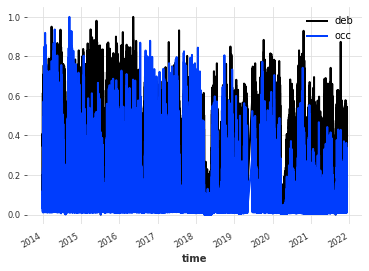

In [6]:
from darts import TimeSeries

from darts.utils.missing_values import fill_missing_values

from darts.dataprocessing.transformers import Scaler
# transform data to TimeSeries

deb = fill_missing_values(TimeSeries.from_dataframe(df,
                                                    value_cols=["deb"],
                                                    fill_missing_dates=True,
                                                    freq='H'))
occ = fill_missing_values(TimeSeries.from_dataframe(df,
                                                    value_cols=["occ"],
                                                    fill_missing_dates=True,
                                                    freq='H'))


scaler_deb, scaler_occ = Scaler(), Scaler()
deb_scaled = scaler_deb.fit_transform(deb)
occ_scaled = scaler_occ.fit_transform(occ)
deb_scaled.plot(label='deb')
occ_scaled.plot(label='occ')
plt.legend()


In [8]:
my_model = NBEATSModel(input_chunk_length=24*7, 
                    output_chunk_length=24,
                    n_epochs=100, random_state=0, 
                    optimizer_kwargs={'lr': 1e-3}, 
                    batch_size=512)

my_model.fit(deb, verbose=True)
pred = my_model.predict(24*5, verbose=True)

df_db_champs=scaler_deb.inverse_transform(pred).pd_dataframe()
df_db_champs.to_csv('deb_sts.csv')

  0%|          | 0/1 [00:00<?, ?it/s]